## Decision Tree Classifier from Scratch

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.plotting._matplotlib import tools

In [142]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples=2, max_thresholds=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.max_thresholds = max_thresholds
        self.root = None
        
    def entropy(self, y):
        """Calculate entropy of a node"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def find_best_split(self, X, y):
        """Optimized best split finder using percentile-based thresholds"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            # Sample threshold values using percentiles
            feature_values = X[:, feature]
            percentiles = np.linspace(0, 100, self.max_thresholds)
            thresholds = np.percentile(feature_values, percentiles)
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                if n_left < self.min_samples or n_right < self.min_samples:
                    continue
                
                # Calculate information gain
                gain = self.entropy(y) - (
                    (n_left / len(y)) * self.entropy(y[left_mask]) +
                    (n_right / len(y)) * self.entropy(y[right_mask])
                )
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        n_samples = len(y)
        
        # Create node
        node = {
            'feature': None,
            'threshold': None,
            'left': None,
            'right': None,
            'value': None,
            'is_leaf': False
        }
        
        # Check stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples or 
            len(np.unique(y)) == 1):
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Find best split
        feature, threshold = self.find_best_split(X, y)
        
        if feature is None:
            node['is_leaf'] = True
            node['value'] = np.bincount(y).argmax()
            return node
        
        # Split the node
        left_mask = X[:, feature] <= threshold
        
        node['feature'] = feature
        node['threshold'] = threshold
        node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self.build_tree(X[~left_mask], y[~left_mask], depth + 1)
        
        return node
    
    def fit(self, X, y):
        """Train the decision tree"""
        self.root = self.build_tree(X, y)
        return self
    
    def predict_one(self, x, node=None):
        """Predict class for a single sample"""
        if node is None:
            node = self.root
            
        if node['is_leaf']:
            return node['value']
            
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        return self.predict_one(x, node['right'])
    
    def predict(self, X):
        """Predict classes for multiple samples"""
        predictions = np.array([self.predict_one(x) for x in X])
        return predictions

Data Preprocessing

In [119]:
# Read data
df = pd.read_csv("car_prices_cleaned.csv")

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440393 entries, 0 to 440392
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440393 non-null  int64  
 1   make          440393 non-null  object 
 2   model         440393 non-null  object 
 3   trim          440393 non-null  object 
 4   body          440393 non-null  object 
 5   transmission  440393 non-null  object 
 6   vin           440393 non-null  object 
 7   state         440393 non-null  object 
 8   condition     440393 non-null  float64
 9   odometer      440393 non-null  float64
 10  color         440393 non-null  object 
 11  interior      440393 non-null  object 
 12  seller        440393 non-null  object 
 13  mmr           440393 non-null  float64
 14  sellingprice  440393 non-null  float64
 15  saledate      440393 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 53.8+ MB


In [121]:
# Convert saledate to datetime with proper format
df['saledate'] = pd.to_datetime(df['saledate'].str.split('GMT').str[0].str.strip(), 
                                  format='%a %b %d %Y %H:%M:%S')

In [122]:
# Calculate features
df['age_at_sale'] = df['saledate'].dt.year - df['year']
df['price_ratio'] = df['sellingprice'] / df['mmr']
df['make_encoded'] = pd.Categorical(df['make']).codes
df['transmission_encoded'] = pd.Categorical(df['transmission']).codes
df['body_encoded'] = pd.Categorical(df['body']).codes    

In [123]:
# Create feature matrix
X = df[['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']].values    

In [124]:
X.shape

(440393, 6)

In [127]:
import pandas as pd

In [129]:
# Definim numele coloanelor pentru claritate
columns = ['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']

# Convertim numpy array X într-un DataFrame Pandas
df_X = pd.DataFrame(X, columns=columns)

# Afișăm primele 10 rânduri pentru verificare
df_X.head(10)


,odometer,price_ratio,make_encoded,age_at_sale,transmission_encoded,body_encoded
0,16639.0000,1.0488,24.0000,-1.0000,0.0000,34.0000
1,9393.0000,1.0337,24.0000,-1.0000,0.0000,34.0000
2,1331.0000,0.9404,3.0000,1.0000,0.0000,35.0000
3,14282.0000,1.0091,51.0000,0.0000,0.0000,35.0000
4,2641.0000,1.0152,3.0000,0.0000,0.0000,35.0000
5,5554.0000,0.7101,36.0000,-1.0000,0.0000,35.0000
6,14943.0000,0.9420,3.0000,0.0000,0.0000,35.0000
7,28617.0000,0.8235,7.0000,0.0000,0.0000,35.0000
8,9557.0000,1.0047,2.0000,0.0000,0.0000,35.0000
9,4809.0000,0.6654,7.0000,1.0000,0.0000,9.0000


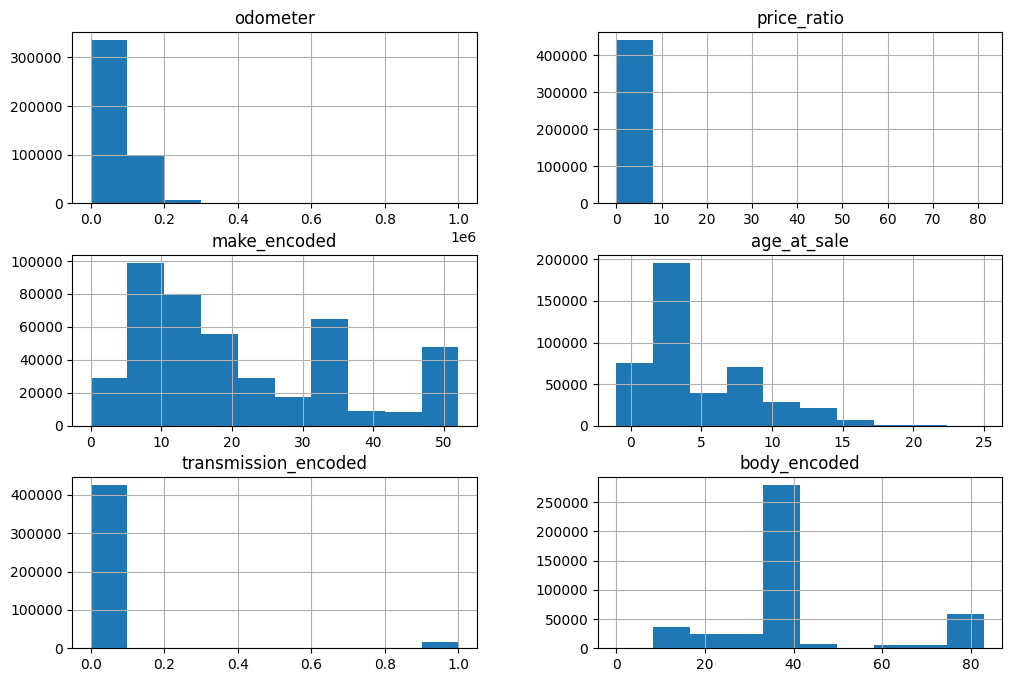

In [88]:
import matplotlib.pyplot as plt

# Define the feature names
feature_names = ['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']

# Convert to a DataFrame with column names
X_df = pd.DataFrame(X, columns=feature_names)

# Plot histograms with feature names
X_df.hist(figsize=(12, 8), bins=10)
plt.show()

In [38]:
# Create target variable
def categorize_condition(score):
    if score <= 10:
        return 1  # Poor
    elif score <= 20:
        return 2  # Fair
    elif score <= 30:
        return 3  # Good
    elif score <= 40:
        return 4  # Very Good
    else:
        return 5  # Excellent

In [39]:
y = df['condition'].apply(categorize_condition).values

In [40]:
y

array([1, 1, 5, ..., 5, 4, 4])

Evaluation Metrics

In [56]:
def evaluate_metrics(y_true, y_pred):
    """
    Calculate all evaluation metrics including:
    - Accuracy
    - Precision
    - Recall (Sensitivity)
    - F-measure (F1-score)
    - AUC (Area under ROC curve)
    - AUPRC (Area under Precision-Recall curve)
    """
    metrics = {}
    
    # Basic metrics
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    # Initialize per-class metrics
    precisions = []
    recalls = []  # same as sensitivity
    f1_scores = []  # same as f-measure
    aucs = []
    auprcs = []
    
    # Convert predictions to one-hot encoding for AUC calculation
    y_true_onehot = np.zeros((len(y_true), n_classes))
    y_pred_onehot = np.zeros((len(y_pred), n_classes))
    
    for i, c in enumerate(classes):
        y_true_onehot[:, i] = (y_true == c)
        y_pred_onehot[:, i] = (y_pred == c)
    
    # Calculate metrics for each class
    for c in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        tn = np.sum((y_true != c) & (y_pred != c))
        
        # Precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisions.append(precision)
        
        # Recall (Sensitivity)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append(recall)
        
        # F-measure (F1-score)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
        
        # Calculate ROC curve and AUC
        # For binary classification of current class vs rest
        y_true_binary = (y_true == c).astype(int)
        y_pred_binary = (y_pred == c).astype(float)
        
        # Sort predictions and corresponding true values
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_binary = y_true_binary[sorted_indices]
        
        # Calculate TPR and FPR at different thresholds
        tpr = np.zeros(len(y_true_binary) + 1)
        fpr = np.zeros(len(y_true_binary) + 1)
        
        for i in range(len(y_true_binary)):
            threshold_tpr = np.sum(y_true_binary[:i+1]) / np.sum(y_true_binary)
            threshold_fpr = np.sum(~y_true_binary.astype(bool)[:i+1]) / np.sum(~y_true_binary.astype(bool))
            tpr[i+1] = threshold_tpr
            fpr[i+1] = threshold_fpr
        
        # Calculate AUC using trapezoid rule
        auc = np.trapezoid(tpr, fpr)
        aucs.append(auc)
        
        # Calculate Precision-Recall curve and AUPRC
        # Sort by prediction scores
        precision_curve = []
        recall_curve = []
        
        for i in range(len(y_true_binary)):
            threshold_tp = np.sum(y_true_binary[:i+1])
            threshold_fp = i + 1 - threshold_tp
            threshold_fn = np.sum(y_true_binary[i+1:])
            
            threshold_precision = threshold_tp / (threshold_tp + threshold_fp) if (threshold_tp + threshold_fp) > 0 else 1
            threshold_recall = threshold_tp / (threshold_tp + threshold_fn) if (threshold_tp + threshold_fn) > 0 else 0
            
            precision_curve.append(threshold_precision)
            recall_curve.append(threshold_recall)
        
        # Calculate AUPRC using trapezoid rule
        auprc = np.trapezoid(precision_curve, recall_curve)
        auprcs.append(auprc)
    
    # Calculate final metrics
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['precision'] = np.mean(precisions)
    metrics['recall'] = np.mean(recalls)
    metrics['sensitivity'] = np.mean(recalls)  # Same as recall
    metrics['f1_score'] = np.mean(f1_scores)
    metrics['auc'] = np.mean(aucs)
    metrics['auprc'] = np.mean(auprcs)
    
    return metrics

In [42]:
# Print dataset information
print("\nClass distribution:")
for cls in range(1, 6):
    print(f"Class {cls}: {np.sum(y == cls)}")


Class distribution:
Class 1: 54744
Class 2: 36111
Class 3: 92472
Class 4: 132076
Class 5: 124990


In [43]:
# Split data (70-30 split)
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.7 * len(X))
train_idx, test_idx = indices[:split], indices[split:]
    
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [44]:
# Train model with optimized classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples=2, max_thresholds=10)
clf.fit(X_train, y_train);

In [45]:
# Make predictions
y_pred = clf.predict(X_test)

In [46]:
# Calculate metrics
metrics = evaluate_metrics(y_test, y_pred)

Metrics calculation completed!


In [47]:
# Print results
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
accuracy: 0.4715
precision: 0.4700
recall: 0.4086
sensitivity: 0.4086
f1_score: 0.4178
auc: 0.6327
auprc: 0.3296


In [51]:
from sklearn.model_selection import KFold

In [52]:
def cross_validate(model, X, y, n_splits=5):
    """
    Perform K-Fold Cross-Validation on the model.
    Returns average metrics across all folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for train_index, test_index in kf.split(X):
        # Împărțim datele în train/test pentru acest fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Antrenăm modelul pe fold-ul curent
        model.fit(X_train, y_train)

        # Realizăm predicții pe setul de test al acestui fold
        y_pred = model.predict(X_test)

        # Calculăm metricile
        fold_metrics = evaluate_metrics(y_test, y_pred)
        all_metrics.append(fold_metrics)

    # Calculăm media metricilor pe toate foldurile
    avg_metrics = {metric: np.mean([fold[metric] for fold in all_metrics]) for metric in all_metrics[0].keys()}
    return avg_metrics

In [53]:
clf = DecisionTreeClassifier(max_depth=5, min_samples=2, max_thresholds=10)

In [54]:
# Cross-Validation
print("Performing Cross-Validation...")
metrics = cross_validate(clf, X, y, n_splits=5)

Performing Cross-Validation...
Metrics calculation completed!
Metrics calculation completed!
Metrics calculation completed!
Metrics calculation completed!
Metrics calculation completed!


In [55]:
print("\nAverage Metrics across all folds:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Average Metrics across all folds:
accuracy: 0.4725
precision: 0.4694
recall: 0.4103
sensitivity: 0.4103
f1_score: 0.4198
auc: 0.6364
auprc: 0.3312


In [58]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_stratified(model, X, y, n_splits=5):
    """Perform Stratified K-Fold Cross-Validation on the model."""
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for train_index, test_index in kf.split(X, y):  # Pass both X and y
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reinitialize model for each fold
        model_fold = DecisionTreeClassifier(max_depth=model.max_depth, 
                                            min_samples=model.min_samples, 
                                            max_thresholds=model.max_thresholds)
        model_fold.fit(X_train, y_train)
        y_pred = model_fold.predict(X_test)

        # Compute evaluation metrics
        fold_metrics = evaluate_metrics(y_test, y_pred)
        all_metrics.append(fold_metrics)

    # Compute the average across all folds
    avg_metrics = {metric: np.mean([fold[metric] for fold in all_metrics]) for metric in all_metrics[0].keys()}
    return avg_metrics

In [59]:
clf = DecisionTreeClassifier(max_depth=5, min_samples=2, max_thresholds=10)

In [60]:
# Cross-Validation
print("Performing Cross-Validation...")
metrics = cross_validate_stratified(clf, X, y, n_splits=5)

Performing Cross-Validation...


In [61]:
print("\nAverage Metrics across all folds:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Average Metrics across all folds:
accuracy: 0.4724
precision: 0.4697
recall: 0.4100
sensitivity: 0.4100
f1_score: 0.4190
auc: 0.6361
auprc: 0.3315


In [62]:
# Cross-Validation
print("Performing Cross-Validation...")
metrics = cross_validate_stratified(clf, X, y, n_splits=10)

Performing Cross-Validation...


In [63]:
print("\nAverage Metrics across all folds:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Average Metrics across all folds:
accuracy: 0.4724
precision: 0.4699
recall: 0.4092
sensitivity: 0.4092
f1_score: 0.4181
auc: 0.6352
auprc: 0.3300


Hyperparameter Optimization

In [64]:
from sklearn.model_selection import KFold
import numpy as np
from itertools import product
import time

In [69]:
def grid_search_cv(model_class, param_grid, X, y, n_splits=5, random_state=42):
    """
    Perform grid search with cross-validation for hyperparameter optimization.
    """
    # Create all possible combinations of parameters
    param_combinations = [dict(zip(param_grid.keys(), v)) 
                         for v in product(*param_grid.values())]
    
    # Initialize variables to store best results
    best_score = -np.inf
    best_params = None
    best_metrics = None
    
    # Create K-fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    start_time = time.time()
    total_combinations = len(param_combinations)
    
    print(f"Starting grid search with {total_combinations} parameter combinations...")
    
    # Iterate through all parameter combinations
    for i, params in enumerate(param_combinations, 1):
        print(f"\nTesting combination {i}/{total_combinations}:")
        print(f"Parameters: {params}")
        
        # Store metrics for all folds
        fold_metrics = []
        
        # Perform k-fold cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Initialize and train model with current parameters
            model = model_class(**params)
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            metrics = evaluate_metrics(y_val, y_pred)
            fold_metrics.append(metrics)
        
        # Calculate average metrics across folds
        avg_metrics = {metric: np.mean([fold[metric] for fold in fold_metrics]) 
                      for metric in fold_metrics[0].keys()}
        
        # Calculate a weighted composite score using multiple metrics
        # Weights can be adjusted based on importance of each metric
        composite_score = (
            0.3 * avg_metrics['accuracy'] +    # Overall accuracy
            0.2 * avg_metrics['f1_score'] +    # Balance between precision and recall
            0.2 * avg_metrics['auc'] +         # Discrimination ability
            0.15 * avg_metrics['precision'] +  # Precision importance
            0.15 * avg_metrics['recall']       # Recall importance
        )
        current_score = composite_score
        
        print(f"Average metrics for this combination:")
        for metric, value in avg_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Update best parameters if current score is better
        if current_score > best_score:
            best_score = current_score
            best_params = params
            best_metrics = avg_metrics
            print("\nNew best combination found!")
            print(f"Best score so far: {best_score:.4f}")
    
    # Calculate total time taken
    total_time = time.time() - start_time
    print(f"\nGrid search completed in {total_time:.2f} seconds")
    
    return {
        'best_params': best_params,
        'best_metrics': best_metrics
    }

In [70]:
# Define Parameter Grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples': [2, 5, 10, 20],
    'max_thresholds': [5, 10, 20, 30]
}

In [71]:
# Run Grid Search
results = grid_search_cv(DecisionTreeClassifier, param_grid, X, y)

Starting grid search with 64 parameter combinations...

Testing combination 1/64:
Parameters: {'max_depth': 3, 'min_samples': 2, 'max_thresholds': 5}
Average metrics for this combination:
accuracy: 0.4427
precision: 0.4120
recall: 0.3622
sensitivity: 0.3622
f1_score: 0.3577
auc: 0.6087
auprc: 0.2945

New best combination found!
Best F1-score so far: 0.4422

Testing combination 2/64:
Parameters: {'max_depth': 3, 'min_samples': 2, 'max_thresholds': 10}
Average metrics for this combination:
accuracy: 0.4389
precision: 0.3690
recall: 0.3560
sensitivity: 0.3560
f1_score: 0.3441
auc: 0.6041
auprc: 0.2935

Testing combination 3/64:
Parameters: {'max_depth': 3, 'min_samples': 2, 'max_thresholds': 20}
Average metrics for this combination:
accuracy: 0.4325
precision: 0.4043
recall: 0.3504
sensitivity: 0.3504
f1_score: 0.3479
auc: 0.6001
auprc: 0.2918

Testing combination 4/64:
Parameters: {'max_depth': 3, 'min_samples': 2, 'max_thresholds': 30}
Average metrics for this combination:
accuracy: 0.4

In [72]:
# Print Results
print("\nBest parameters found:")
print(results['best_params'])
print("\nBest metrics achieved:")
for metric, value in results['best_metrics'].items():
    print(f"{metric}: {value:.4f}")


Best parameters found:
{'max_depth': 10, 'min_samples': 2, 'max_thresholds': 30}

Best metrics achieved:
accuracy: 0.4911
precision: 0.4967
recall: 0.4364
sensitivity: 0.4364
f1_score: 0.4505
auc: 0.6515
auprc: 0.3527


In [73]:
# Create and train model with best parameters
best_model = DecisionTreeClassifier(**results['best_params'])
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate and print final metrics
final_metrics = evaluate_metrics(y_test, y_pred)
print("\nFinal Test Set Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Test Set Metrics:
accuracy: 0.4887
precision: 0.4935
recall: 0.4300
sensitivity: 0.4300
f1_score: 0.4446
auc: 0.6454
auprc: 0.3490


Statistical Analysis (Confidence Intervals & Standard Deviation)

In [81]:
from scipy import stats
import numpy as np
import pandas as pd

def analyze_best_model_stats(model_class, best_params, X, y, n_splits=5, confidence=0.95):
    """
    Perform statistical analysis on the best model from grid search.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []
    
    print("Performing statistical analysis on best model...")
    print(f"Best parameters being analyzed: {best_params}")
    
    # Perform cross-validation with the best parameters
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train and evaluate model
        model = model_class(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics for this fold
        metrics = evaluate_metrics(y_test, y_pred)
        fold_metrics.append(metrics)
        
        print(f"Completed fold {fold}/{n_splits}")
    
    # Calculate statistics for each metric
    stats_results = {}
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        mean = np.mean(values)
        std_dev = np.std(values, ddof=1)  # Using sample standard deviation
        
        # Calculate confidence interval
        n = len(values)
        t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
        ci_half_width = t_value * (std_dev / np.sqrt(n))
        ci = (mean - ci_half_width, mean + ci_half_width)
        
        # Store results
        stats_results[metric] = {
            "Values": values,
            "Mean": mean,
            "Standard Deviation": std_dev,
            "Confidence Interval": ci,
            "CV (%)": (std_dev / mean) * 100 if mean != 0 else np.inf
        }
    
    return stats_results

In [82]:
def display_model_statistics(stats_results):
    """
    Display the statistical analysis results in a formatted way.
    """
    print("\n" + "="*60)
    print("Statistical Analysis of Best Model Performance")
    print("="*60 + "\n")
    
    # Create DataFrame for clean display
    stats_df = pd.DataFrame(columns=['Mean', 'Std Dev', 'CV (%)', 'CI Lower', 'CI Upper'])
    
    for metric, stats in stats_results.items():
        stats_df.loc[metric] = [
            stats['Mean'],
            stats['Standard Deviation'],
            stats['CV (%)'],
            stats['Confidence Interval'][0],
            stats['Confidence Interval'][1]
        ]
    
    # Format and display results
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    print(stats_df)
    
    # Print detailed analysis
    print("\nDetailed Analysis:")
    print("-"*60)
    for metric, stats in stats_results.items():
        print(f"\n📊 {metric.upper()}")
        print(f"   ├ Mean                : {stats['Mean']:.4f}")
        print(f"   ├ Standard Deviation  : {stats['Standard Deviation']:.4f}")
        print(f"   ├ CV (%)             : {stats['CV (%)']:.2f}")
        print(f"   └ 95% CI             : ({stats['Confidence Interval'][0]:.4f}, "
              f"{stats['Confidence Interval'][1]:.4f})")

In [83]:
best_model_stats = analyze_best_model_stats(
    DecisionTreeClassifier,
    results['best_params'],  # From your grid search
    X,
    y,
    n_splits=5
)

Performing statistical analysis on best model...
Best parameters being analyzed: {'max_depth': 10, 'min_samples': 2, 'max_thresholds': 30}
Completed fold 1/5
Completed fold 2/5
Completed fold 3/5
Completed fold 4/5
Completed fold 5/5


In [84]:
display_model_statistics(best_model_stats)


Statistical Analysis of Best Model Performance

              Mean  Std Dev  CV (%)  CI Lower  CI Upper
accuracy    0.4911   0.0005  0.1062    0.4904    0.4917
precision   0.4967   0.0021  0.4297    0.4941    0.4994
recall      0.4364   0.0014  0.3177    0.4347    0.4381
sensitivity 0.4364   0.0014  0.3177    0.4347    0.4381
f1_score    0.4505   0.0013  0.2909    0.4488    0.4521
auc         0.6515   0.0006  0.0930    0.6508    0.6523
auprc       0.3527   0.0007  0.2044    0.3518    0.3536

Detailed Analysis:
------------------------------------------------------------

📊 ACCURACY
   ├ Mean                : 0.4911
   ├ Standard Deviation  : 0.0005
   ├ CV (%)             : 0.11
   └ 95% CI             : (0.4904, 0.4917)

📊 PRECISION
   ├ Mean                : 0.4967
   ├ Standard Deviation  : 0.0021
   ├ CV (%)             : 0.43
   └ 95% CI             : (0.4941, 0.4994)

📊 RECALL
   ├ Mean                : 0.4364
   ├ Standard Deviation  : 0.0014
   ├ CV (%)             : 0.32
   └

In [92]:
import pandas as pd

# Funcție de normalizare min-max fără librării externe
def min_max_normalize(df):
    df_normalized = df.copy()
    
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:  # Verifică dacă este coloană numerică
            min_val = df[column].min()
            max_val = df[column].max()
            if max_val != min_val:  # Evită împărțirea la zero
                df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
            else:
                df_normalized[column] = 0  # Dacă toate valorile sunt egale, normalizăm la 0
    
    return df_normalized

# Aplicare pe DataFrame-ul tău
df_normalized = min_max_normalize(df)

In [93]:
df_normalized

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,mmr,sellingprice,saledate,age_at_sale,price_ratio,make_encoded,transmission_encoded,body_encoded
0,1.0000,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,0.0833,0.0166,...,black,kia motors america inc,0.1125,0.0935,2014-12-16 12:30:00,0.0000,0.0129,24,0,34
1,1.0000,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,0.0833,0.0094,...,beige,kia motors america inc,0.1142,0.0935,2014-12-16 12:30:00,0.0000,0.0127,24,0,34
2,0.9600,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,0.9167,0.0013,...,black,financial services remarketing (lease),0.1752,0.1304,2015-01-15 04:30:00,0.0769,0.0116,3,0,35
3,1.0000,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,0.8333,0.0143,...,black,volvo na rep/world omni,0.1510,0.1206,2015-01-29 04:30:00,0.0385,0.0124,51,0,35
4,0.9600,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,0.8750,0.0026,...,black,financial services remarketing (lease),0.3625,0.2913,2014-12-18 12:30:00,0.0385,0.0125,3,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440388,0.8400,BMW,5 Series,528i,Sedan,automatic,wbafr1c53bc744672,fl,0.7917,0.0664,...,brown,lauderdale imports ltd bmw pembrok pines,0.1114,0.0991,2015-07-07 06:15:00,0.1923,0.0138,3,0,35
440389,0.8800,Ram,2500,Power Wagon,Crew Cab,automatic,3c6td5et6cg112407,wa,0.0833,0.0544,...,black,i -5 uhlmann rv,0.1658,0.1339,2015-07-08 09:30:00,0.1538,0.0125,41,0,11
440390,0.8800,BMW,X5,xDrive35d,SUV,automatic,5uxzw0c58cl668465,ca,0.9792,0.0506,...,black,financial services remarketing (lease),0.1636,0.1478,2015-07-08 09:30:00,0.1538,0.0140,3,0,34
440391,1.0000,Nissan,Altima,2.5 S,sedan,automatic,1n4al3ap0fc216050,ga,0.7708,0.0167,...,black,enterprise vehicle exchange / tra / rental / t...,0.0828,0.0483,2015-07-09 06:45:00,0.0385,0.0090,36,0,75


In [94]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440393 entries, 0 to 440392
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   year                  440393 non-null  float64       
 1   make                  440393 non-null  object        
 2   model                 440393 non-null  object        
 3   trim                  440393 non-null  object        
 4   body                  440393 non-null  object        
 5   transmission          440393 non-null  object        
 6   vin                   440393 non-null  object        
 7   state                 440393 non-null  object        
 8   condition             440393 non-null  float64       
 9   odometer              440393 non-null  float64       
 10  color                 440393 non-null  object        
 11  interior              440393 non-null  object        
 12  seller                440393 non-null  object        
 13 

In [101]:
import pandas as pd

def manual_label_encoding(df):
    df_encoded = df_normalized.copy()
    encoding_maps = {} 

    for column in df_normalized.columns:
        if df_normalized[column].dtype == 'object':  # Verificăm dacă e coloană categorială
            unique_values = sorted(df_normalized[column].unique())  # Sortăm pentru consistență
            encoding_map = {val: idx for idx, val in enumerate(unique_values)}  # Mapare valori -> numere
            df_encoded[column] = df_normalized[column].map(encoding_map)  # Aplicăm encoding-ul
            encoding_maps[column] = encoding_map  # Salvăm maparea pentru referință

    return df_encoded, encoding_maps

# Aplicare pe DataFrame
df_encoded, encoding_maps = manual_label_encoding(df_normalized)

# Afișare mapare pentru referință
for col, mapping in encoding_maps.items():
    print(f"Encodare pentru {col}: {mapping}\n")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [102]:
df_encoded

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,mmr,sellingprice,saledate,age_at_sale,price_ratio,make_encoded,transmission_encoded,body_encoded
0,1.0000,24,634,817,34,0,319370,2,0.0833,0.0166,...,1,5864,0.1125,0.0935,2014-12-16 12:30:00,0.0000,0.0129,24,0,34
1,1.0000,24,634,817,34,0,319364,2,0.0833,0.0094,...,0,5864,0.1142,0.0935,2014-12-16 12:30:00,0.0000,0.0127,24,0,34
2,0.9600,3,8,252,35,0,402432,2,0.9167,0.0013,...,1,4031,0.1752,0.1304,2015-01-15 04:30:00,0.0769,0.0116,3,0,35
3,1.0000,51,572,1208,35,0,431530,2,0.8333,0.0143,...,1,11335,0.1510,0.1206,2015-01-29 04:30:00,0.0385,0.0124,51,0,35
4,0.9600,3,33,334,35,0,403149,2,0.8750,0.0026,...,1,4031,0.3625,0.2913,2014-12-18 12:30:00,0.0385,0.0125,3,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440388,0.8400,3,25,315,35,0,405208,4,0.7917,0.0664,...,3,6135,0.1114,0.0991,2015-07-07 06:15:00,0.1923,0.0138,3,0,35
440389,0.8800,41,6,925,11,0,229759,32,0.0833,0.0544,...,1,5271,0.1658,0.1339,2015-07-08 09:30:00,0.1538,0.0125,41,0,11
440390,0.8800,3,719,1485,34,0,314801,2,0.9792,0.0506,...,1,4031,0.1636,0.1478,2015-07-08 09:30:00,0.1538,0.0140,3,0,34
440391,1.0000,36,63,102,75,0,152045,5,0.7708,0.0167,...,1,3730,0.0828,0.0483,2015-07-09 06:45:00,0.0385,0.0090,36,0,75


In [103]:
# Create feature matrix
X = df_encoded[['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']].values    

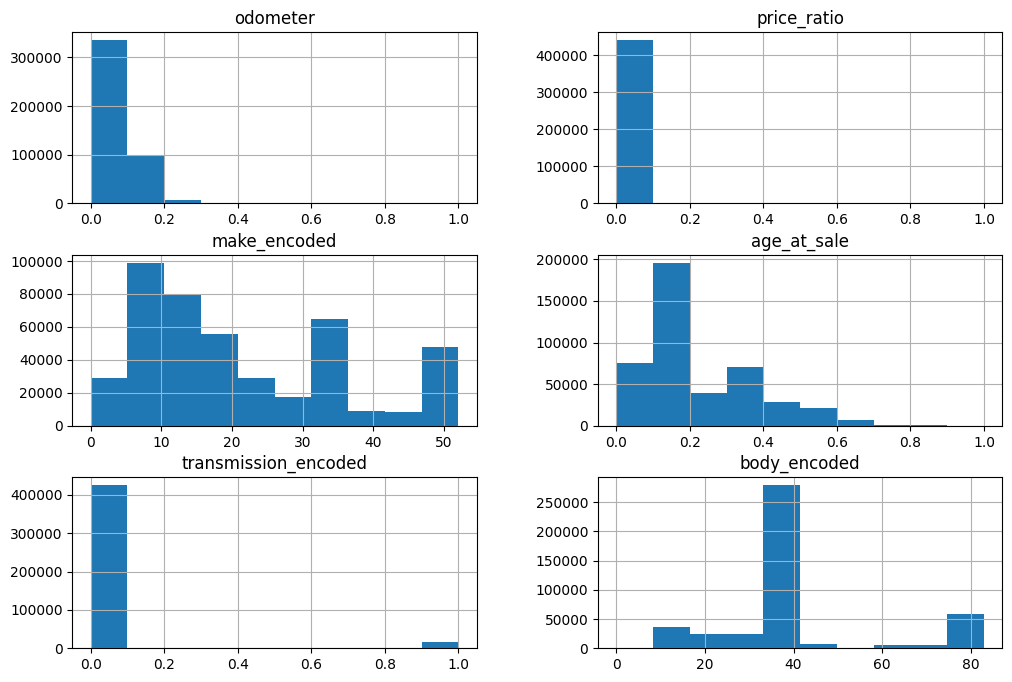

In [104]:
import matplotlib.pyplot as plt

# Define the feature names
feature_names = ['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']

# Convert to a DataFrame with column names
X_df = pd.DataFrame(X, columns=feature_names)

# Plot histograms with feature names
X_df.hist(figsize=(12, 8), bins=10)
plt.show()

In [130]:
# Split data (70-30 split)
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.7 * len(X))
train_idx, test_idx = indices[:split], indices[split:]
    
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [110]:
clf = DecisionTreeClassifier(max_depth=10, min_samples=2, max_thresholds=30)

In [114]:
clf.fit(X_train, y_train)

In [115]:
# Make predictions
y_pred = best_model.predict(X_test)

# Calculate and print final metrics
final_metrics = evaluate_metrics(y_test, y_pred)
print("\nFinal Test Set Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Test Set Metrics:
accuracy: 0.1275
precision: 0.0774
recall: 0.1997
sensitivity: 0.1997
f1_score: 0.0494
auc: 0.4992
auprc: 0.1998


In [132]:
# Pt X nenormalizat:
clf = DecisionTreeClassifier(max_depth=10, min_samples=2, max_thresholds=30)

In [133]:
clf.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate and print final metrics
final_metrics = evaluate_metrics(y_test, y_pred)
print("\nFinal Test Set Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Test Set Metrics:
accuracy: 0.4887
precision: 0.4935
recall: 0.4300
sensitivity: 0.4300
f1_score: 0.4446
auc: 0.6454
auprc: 0.3490


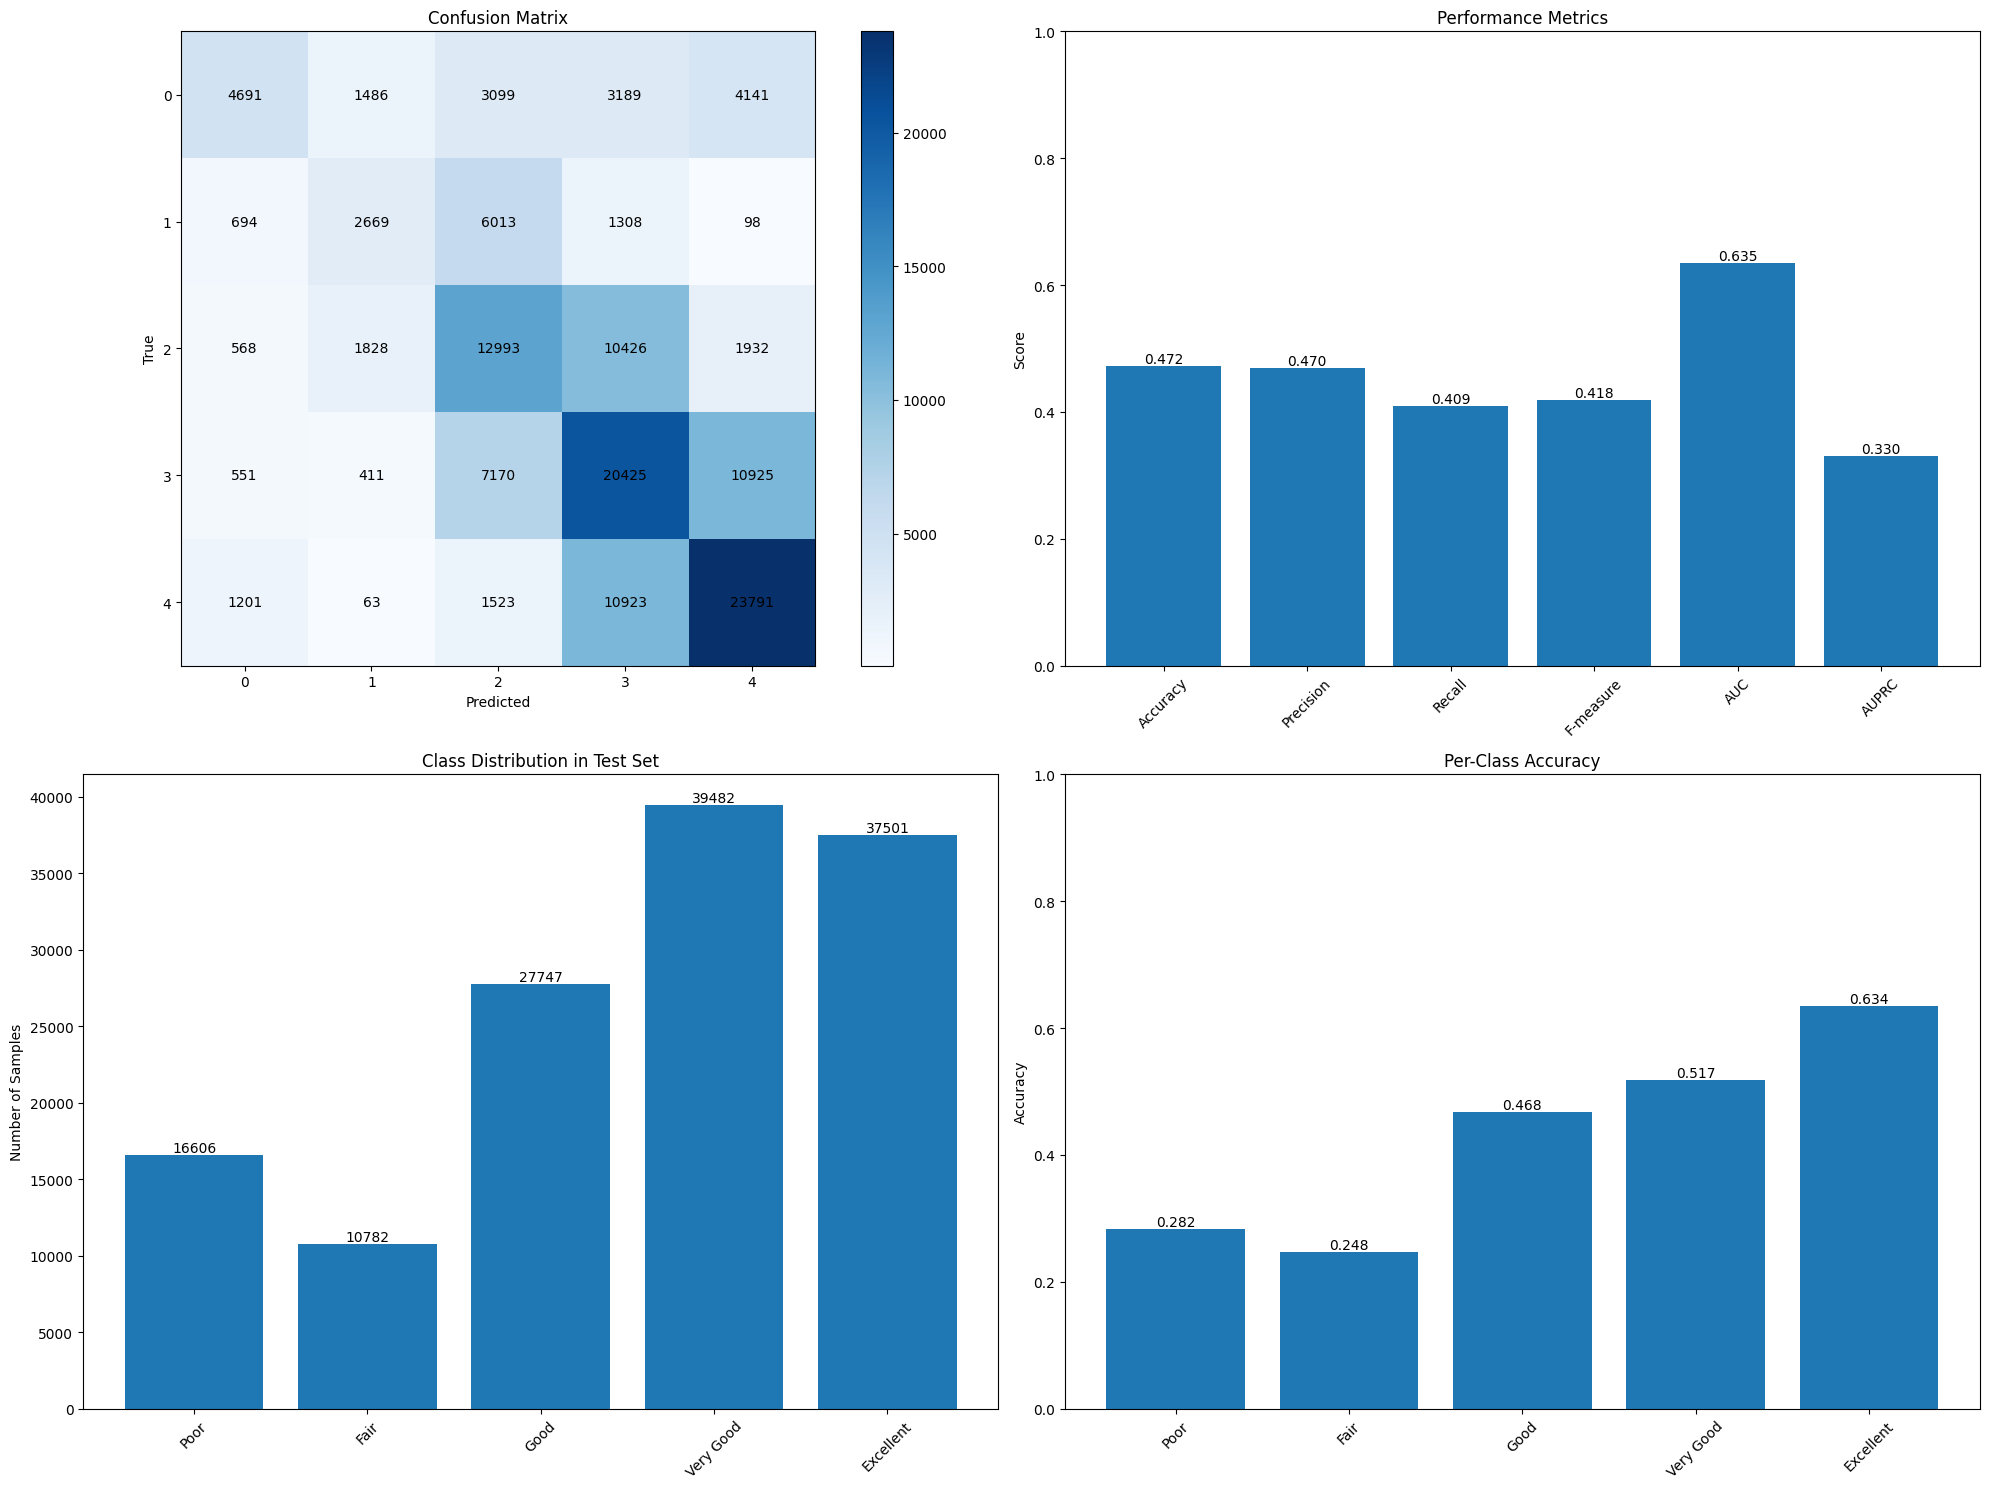

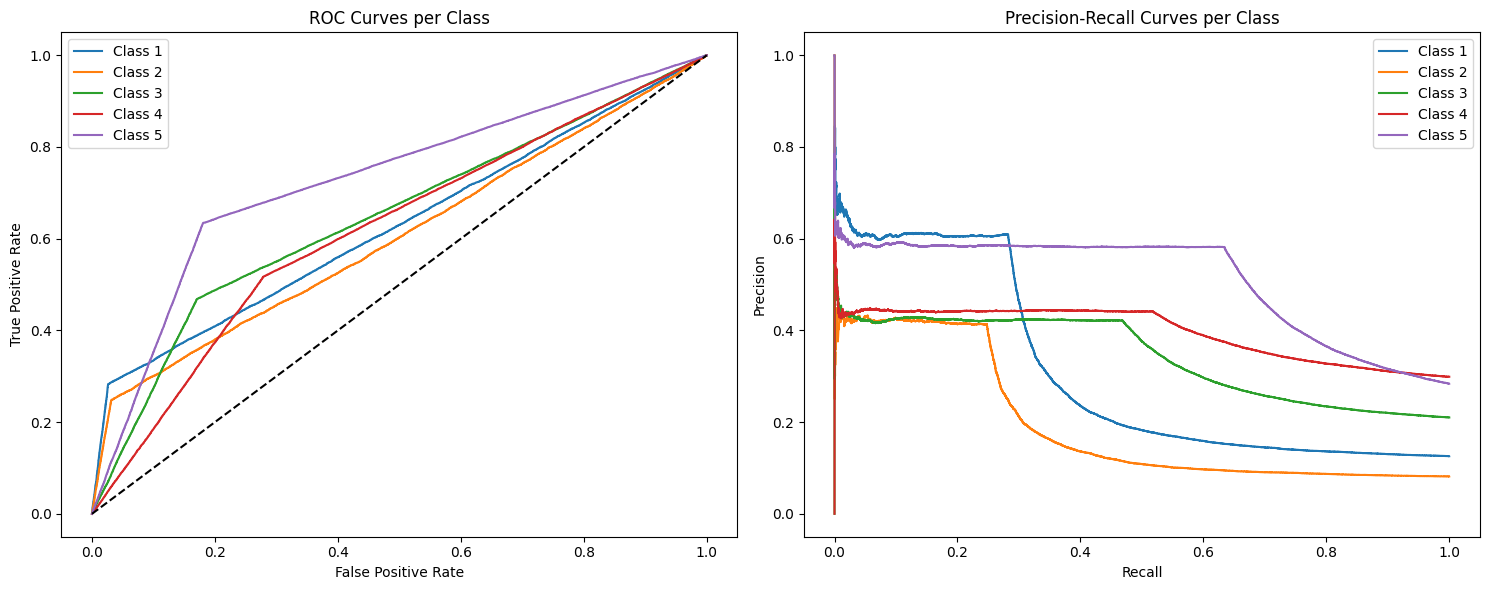

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_results(y_test, y_pred, metrics):
    """
    Create comprehensive visualizations for the classification results
    """
    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                    ha="center", va="center")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # 2. Performance Metrics Bar Plot
    plt.subplot(2, 2, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F-measure', 'AUC', 'AUPRC']
    metric_values = [metrics['accuracy'], metrics['precision'], 
                    metrics['recall'], metrics['f1_score'], 
                    metrics['auc'], metrics['auprc']]
    
    bars = plt.bar(metric_names, metric_values)
    plt.title('Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # 3. Class Distribution
    plt.subplot(2, 2, 3)
    class_counts = [np.sum(y_test == i) for i in range(1, 6)]
    class_names = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    bars = plt.bar(class_names, class_counts)
    plt.title('Class Distribution in Test Set')
    plt.ylabel('Number of Samples')
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # 4. Per-Class Performance
    plt.subplot(2, 2, 4)
    per_class_accuracy = []
    for i in range(1, 6):
        mask = y_test == i
        acc = np.mean(y_pred[mask] == y_test[mask])
        per_class_accuracy.append(acc)
    
    bars = plt.bar(class_names, per_class_accuracy)
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    plt.xticks(rotation=45)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Create ROC and PR curves (new figure)
    plt.figure(figsize=(15, 6))
    
    # 5. ROC Curves
    plt.subplot(1, 2, 1)
    for i in range(1, 6):
        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (y_pred == i).astype(float)
        
        # Calculate TPR and FPR
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_sorted = y_true_binary[sorted_indices]
        
        tpr = np.zeros(len(y_true_binary) + 1)
        fpr = np.zeros(len(y_true_binary) + 1)
        
        for j in range(len(y_true_binary)):
            tpr[j+1] = np.sum(y_true_sorted[:j+1]) / np.sum(y_true_binary)
            fpr[j+1] = np.sum(~y_true_sorted[:j+1].astype(bool)) / np.sum(~y_true_binary.astype(bool))
        
        plt.plot(fpr, tpr, label=f'Class {i}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves per Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # 6. Precision-Recall Curves
    plt.subplot(1, 2, 2)
    for i in range(1, 6):
        y_true_binary = (y_test == i).astype(int)
        y_pred_binary = (y_pred == i).astype(float)
        
        # Sort by prediction scores
        sorted_indices = np.argsort(y_pred_binary)[::-1]
        y_true_sorted = y_true_binary[sorted_indices]
        
        precision_curve = []
        recall_curve = []
        
        for j in range(len(y_true_binary)):
            tp = np.sum(y_true_sorted[:j+1])
            fp = j + 1 - tp
            fn = np.sum(y_true_sorted[j+1:])
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 1
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            precision_curve.append(precision)
            recall_curve.append(recall)
        
        plt.plot(recall_curve, precision_curve, label=f'Class {i}')
    
    plt.title('Precision-Recall Curves per Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# After your model evaluation, use:
plot_results(y_test, y_pred, metrics)

ExactExplainer explainer: 132119it [07:46, 279.12it/s]                            



Importanța procentuală a caracteristicilor bazată pe valorile SHAP:
price_ratio            41.5138
odometer               23.4128
age_at_sale            22.9523
make_encoded           12.1210
transmission_encoded    0.0000
body_encoded            0.0000
dtype: float64


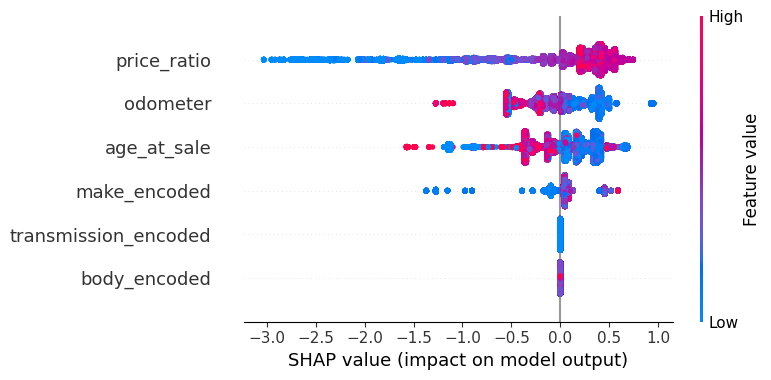

In [144]:
import shap
import numpy as np
import pandas as pd

# Wrapper pentru compatibilitatea modelului cu SHAP (opțional)
class DecisionTreeSHAPWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

# Pregătirea modelului și a datelor
clf_shap = DecisionTreeSHAPWrapper(DecisionTreeClassifier(max_depth=10, min_samples=2, max_thresholds=30))
clf_shap.fit(X_train, y_train)

# SHAP Explainer
explainer = shap.Explainer(clf_shap.predict, X_train)

# Calculăm valorile SHAP
shap_values = explainer(X_test)

# Calcularea valorilor procentuale pentru caracteristici
shap_values_df = pd.DataFrame(
    shap_values.values,
    columns=['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded']
)

# Calculăm importanța absolută medie și procentuală
shap_feature_importance = shap_values_df.abs().mean()
shap_feature_importance_percent = (shap_feature_importance / shap_feature_importance.sum()) * 100

# Sortăm caracteristicile în funcție de importanță
shap_feature_importance_percent = shap_feature_importance_percent.sort_values(ascending=False)

# Afișăm importanța procentuală
print("\nImportanța procentuală a caracteristicilor bazată pe valorile SHAP:")
print(shap_feature_importance_percent)

# Vizualizare grafică cu SHAP
shap.summary_plot(shap_values, X_test, feature_names=['odometer', 'price_ratio', 'make_encoded', 'age_at_sale', 'transmission_encoded', 'body_encoded'])

## Decision Tree Classifier using libraries

In [145]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [147]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42)

clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4886


In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

In [153]:
# Calculează metricele standard
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Binarizează etichetele pentru clasificarea multi-clasă
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Obține probabilitățile pentru fiecare clasă
y_proba = clf.predict_proba(X_test)

# Calculează AUC și AUPRC folosind media macro
auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
auprc = average_precision_score(y_test_bin, y_proba, average="macro")

# Afișează metricele
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Sensitivity: {recall:.4f}")  # Sensitivity este echivalent cu Recall
print(f"F1 Score: {f1:.4f}")
print(f"AUC (macro-average): {auc:.4f}")
print(f"AUPRC (macro-average): {auprc:.4f}")

Accuracy: 0.4886
Precision: 0.4979
Recall: 0.4886
Sensitivity: 0.4886
F1 Score: 0.4826
AUC (macro-average): 0.7749
AUPRC (macro-average): 0.4413
